# Lab 4: Sequential Data - [57 pts]

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

# PART A - Spam Detection [33 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part A.1 Data Cleaning - [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part A.1.a - [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:

for line in open('SMSSpamCollection'):
    if line[0] =='h':
      print("The label of the non-spam message is: ham.")
      print(line)
      break

for line in open('SMSSpamCollection'):
  if line[0]=='s':
    print("The label of the spam message is: spam.")
    print(line)
    break
  
    

The label of the non-spam message is: ham.
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The label of the spam message is: spam.
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
# The label of a non-spam message is "ham" and the label for a spam message is "spam"

### Part A.1.b - [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
non_spam = 0
spam = 0
for line in open('SMSSpamCollection'):
  if line[0]=='h':
    non_spam +=1
  if line[0]=='s':
    spam +=1

print("There is {} non-spam messages in the dataset".format(non_spam))
print("There is {} spam messages in the dataset".format(spam))

There is 4827 non-spam messages in the dataset
There is 747 spam messages in the dataset


### Part A.1.c - [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# Adavantage:
  # There are less characters than words in the dataset, therefore modeling SMS as a sequence of characters improves memory allocation
  # Model would generalize better as the chances of observing a unknown word is much higher than observing an unkown character in the message


# Disadvantage:
  # Training would take longer as some sentences would have more characters than words 
  # The network woudl not be able to determine the meaning of the message. As meaning come from the context of words in a sentence, modeling the
  # data based on character would mean that sentence meaning is lost. 
  

### Part A.1.d - [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
!pip uninstall torchtext

Found existing installation: torchtext 0.9.0
Uninstalling torchtext-0.9.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/torchtext-0.9.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/torchtext/*
Proceed (Y/n)? Y
  Successfully uninstalled torchtext-0.9.0


In [ ]:
!pip install torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchtext-0.9.0-cp39-cp39-manylinux1_x86_64.whl (7.0 MB)
  Using cached torch-1.8.0-cp39-cp39-manylinux1_x86_64.whl (735.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.


In [ ]:
import torchtext
import random

In [ ]:
from torchtext.legacy import data


In [ ]:
text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

#dataset[0].sms
#dataset[0].label
train, valid, test = dataset.split(split_ratio =[0.6,0.2,0.2] , random_state = random.getstate())

In [ ]:
print(len(list(train)))
print(len(list(valid)))
print(len(list(test)))

3343
1115
1114


### Part A.1.e - [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# having a balanced training set is helpful for training the neural network because the model needs to be trained on as many spam and non-spam 
# messages in order to be able to classify properly spam and non-spam messages when the model is subjected to a set of new data, i.e., the testing
# data. Else the neural network would not be able to detect the disparities between the spam and non-spam messages if non-spam messages number was
# limited.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part A.1.f - [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
# text_field.vocab.stoi represents the index at which each element was found in the training dataset
#  text_field.vocab.itos represents the characters that were found in the training dataset

In [ ]:
text_field.build_vocab(train)

In [ ]:
list(text_field.vocab.stoi.keys())[:10]
list(text_field.vocab.stoi.items())[:10]


[('<unk>', 0),
 ('<pad>', 1),
 (' ', 2),
 ('e', 3),
 ('o', 4),
 ('t', 5),
 ('a', 6),
 ('n', 7),
 ('r', 8),
 ('i', 9)]

In [ ]:
text_field.vocab.itos[:10]

['<unk>', '<pad>', ' ', 'e', 'o', 't', 'a', 'n', 'r', 'i']

### Part A.1.g - [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <pad> represents padding that was added to the sentence to maintain length consistency
# <unk> represents a character that is not in the vocabulary of torchtext

### Part A.1.h - [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i=0
for batch in train_iter:
    pad_count = 0
    print("The maximum length of the input sequence in batch {} is :{}".format(i+1 , torch.max(batch.sms[1])))

    for j in range(len(batch.sms[0])):
      pad_count = pad_count + np.count_nonzero(batch.sms[0][j]==1)
      
    print("The number of pads  used in batch {} is : {} \n".format(i+1 , pad_count))
    
    
    i+=1

    if i==10:
      break

The maximum length of the input sequence in batch 1 is :126
The number of pads  used in batch 1 is : 29 

The maximum length of the input sequence in batch 2 is :32
The number of pads  used in batch 2 is : 12 

The maximum length of the input sequence in batch 3 is :158
The number of pads  used in batch 3 is : 0 

The maximum length of the input sequence in batch 4 is :158
The number of pads  used in batch 4 is : 0 

The maximum length of the input sequence in batch 5 is :146
The number of pads  used in batch 5 is : 0 

The maximum length of the input sequence in batch 6 is :146
The number of pads  used in batch 6 is : 31 

The maximum length of the input sequence in batch 7 is :38
The number of pads  used in batch 7 is : 26 

The maximum length of the input sequence in batch 8 is :73
The number of pads  used in batch 8 is : 34 

The maximum length of the input sequence in batch 9 is :159
The number of pads  used in batch 9 is : 0 

The maximum length of the input sequence in batch 10 

## Part A.2 Model Building - [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 6]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]])


In [ ]:
ident[x]

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]])

In [ ]:
def encoding_embedding(x):
  text_field.build_vocab(train)
  ident = torch.eye(len(text_field.vocab.stoi))

  for i in range(0,len(x)):
    encod = ident[x[i]].unsqueeze(0)

    if i==0:
      encod_new = encod
    else:
      encod_new = torch.cat((encod_new , encod) , dim = 0)
      
  return encod_new


In [ ]:
class LSTM(nn.Module):
  def  __init__(self, input_size, hidden_size, num_class):
    super(LSTM, self).__init__()
  
    self.emb = encoding_embedding
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)

  def forward(self , x):
    x = self.emb(x)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, __ = self.rnn(x, (h0, c0))
    
    out = self.fc(torch.max(out, dim=1)[0])

    return out


## Part A.3 Training - [8 pt]

### Part A.3.a - [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0 
    total = 0

    for batch in data:
      batch_length = len(batch)
      y = batch.sms[0]
      correct_label = batch.label
      output = model(y)
      pred = output.max(1 , keepdim = True)[1]
      correct += pred.eq(correct_label.view_as(pred)).sum().item()
      total += batch_length
    return correct/total

    

### Part A.3.b - [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
model = LSTM(len(text_field.vocab.stoi),50,2)


In [ ]:
import matplotlib.pyplot as plt

def train_net(model,train,valid, num_epochs = 30 , learning_rate =0.001):
  optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)
  criterion = nn.CrossEntropyLoss()
  losses , train_accuracy, valid_accuracy = [],[],[]
  epochs =[]


  for epoch in range(num_epochs):
    for batch in train:
      optimizer.zero_grad()
      prediction = model(batch.sms[0])
      loss = criterion(prediction, batch.label)
      loss.backward()
      optimizer.step()
    losses.append(float(loss))

    epochs.append(epoch)
    train_accuracy.append(get_accuracy(model , train))
    valid_accuracy.append(get_accuracy(model, valid))

    print("Epoch : {} ; Loss: {} ; Train_Acc: {} ; Val_Acc: {} ".format(epoch+1, loss , 
                                                                        train_accuracy[-1] , valid_accuracy[-1]))

  
  plt.title("Training Curve")
  plt.plot(losses , label = "Train")
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.show()


  plt.title("Trainin Curve")
  plt.plot(epochs , train_accuracy , label = 'Train')
  plt.plot(epochs, valid_accuracy , label = 'Validation')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc = 'best')
  plt.show()
        

In [ ]:
train_iter1 = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
val_iter1 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch : 1 ; Loss: 0.5130583047866821 ; Train_Acc: 0.9202886390333949 ; Val_Acc: 0.9730941704035875 
Epoch : 2 ; Loss: 0.13759569823741913 ; Train_Acc: 0.9449572075851653 ; Val_Acc: 0.968609865470852 
Epoch : 3 ; Loss: 0.024538476020097733 ; Train_Acc: 0.9573753985568049 ; Val_Acc: 0.9596412556053812 
Epoch : 4 ; Loss: 0.027941912412643433 ; Train_Acc: 0.9551938244671925 ; Val_Acc: 0.9605381165919282 
Epoch : 5 ; Loss: 0.023532623425126076 ; Train_Acc: 0.9644235610001678 ; Val_Acc: 0.9533632286995516 
Epoch : 6 ; Loss: 0.2217119336128235 ; Train_Acc: 0.9603960396039604 ; Val_Acc: 0.9497757847533632 
Epoch : 7 ; Loss: 0.2485668659210205 ; Train_Acc: 0.9672763886558148 ; Val_Acc: 0.9533632286995516 
Epoch : 8 ; Loss: 0.14207571744918823 ; Train_Acc: 0.9733176707501259 ; Val_Acc: 0.9623318385650225 
Epoch : 9 ; Loss: 0.08554747700691223 ; Train_Acc: 0.9729820439671085 ; Val_Acc: 0.9704035874439462 
Epoch : 10 ; Loss: 0.0582452155649662 ; Train_Acc: 0.9820439671085752 ; Val_Acc: 0.966816143

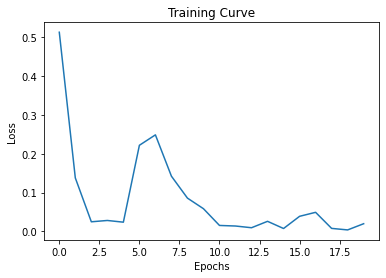

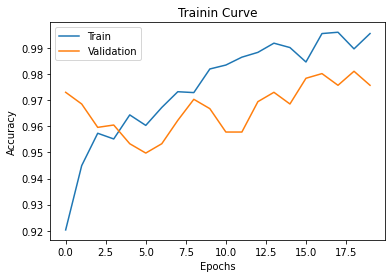

In [ ]:
train_net(model , train_iter1, val_iter1 , num_epochs = 20 , learning_rate = 1e-3)

### Part A.3.c - [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
model = LSTM(len(text_field.vocab.stoi),50,2)


In [ ]:
# Hyperparameter 1: Inceasing Batch_size

train_iter2 = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)   

val_iter2 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Epoch : 1 ; Loss: 0.3243555724620819 ; Train_Acc: 0.916109025624286 ; Val_Acc: 0.9094170403587444 
Epoch : 2 ; Loss: 0.2597777843475342 ; Train_Acc: 0.9193732658723682 ; Val_Acc: 0.9713004484304932 
Epoch : 3 ; Loss: 0.5146511793136597 ; Train_Acc: 0.9423861596213481 ; Val_Acc: 0.9632286995515695 
Epoch : 4 ; Loss: 0.1764945387840271 ; Train_Acc: 0.9520156683531908 ; Val_Acc: 0.9641255605381166 
Epoch : 5 ; Loss: 0.13594843447208405 ; Train_Acc: 0.9471193079810674 ; Val_Acc: 0.9713004484304932 
Epoch : 6 ; Loss: 0.26345494389533997 ; Train_Acc: 0.9417333115717317 ; Val_Acc: 0.9067264573991032 
Epoch : 7 ; Loss: 0.04750002175569534 ; Train_Acc: 0.9560959686632936 ; Val_Acc: 0.957847533632287 
Epoch : 8 ; Loss: 0.08063759654760361 ; Train_Acc: 0.9575648767749306 ; Val_Acc: 0.9506726457399103 
Epoch : 9 ; Loss: 0.10066846758127213 ; Train_Acc: 0.9590337848865677 ; Val_Acc: 0.9524663677130045 
Epoch : 10 ; Loss: 0.03658055141568184 ; Train_Acc: 0.933409498939122 ; Val_Acc: 0.97668161434977

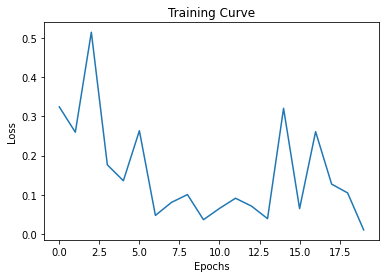

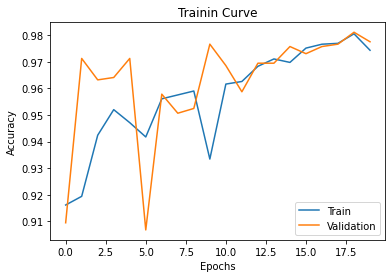

In [ ]:
train_net(model , train_iter2, val_iter2 , num_epochs = 20 , learning_rate = 1e-3)

In [ ]:
#Hyperparamter 2 : testing best LTSM model with Average_pool rather than Max_pool

class LSTM_Network_mean(nn.Module):
  def  __init__(self, input_size, hidden_size, num_class):
    super(LSTM_Network_mean, self).__init__()
  
    self.emb = encoding_embedding
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)

  def forward(self , x):
    x = self.emb(x)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, __ = self.rnn(x, (h0, c0))
    
    out = self.fc(torch.mean(out, dim=1))
    
    return out


In [ ]:
# This model performs worse that MaxPooling the last layer

In [ ]:
model2 = LSTM_Network_mean(len(text_field.vocab.stoi),50,2)

Epoch : 1 ; Loss: 0.3197256624698639 ; Train_Acc: 0.8511506446874489 ; Val_Acc: 0.9551569506726457 
Epoch : 2 ; Loss: 0.0401080958545208 ; Train_Acc: 0.9087644850661009 ; Val_Acc: 0.9623318385650225 
Epoch : 3 ; Loss: 0.05268053337931633 ; Train_Acc: 0.9164354496490942 ; Val_Acc: 0.9659192825112107 
Epoch : 4 ; Loss: 0.37362033128738403 ; Train_Acc: 0.9399379794352865 ; Val_Acc: 0.9434977578475336 
Epoch : 5 ; Loss: 0.022604815661907196 ; Train_Acc: 0.9327566508895054 ; Val_Acc: 0.9381165919282511 
Epoch : 6 ; Loss: 0.6834834814071655 ; Train_Acc: 0.9379794352864371 ; Val_Acc: 0.9659192825112107 
Epoch : 7 ; Loss: 0.1716366410255432 ; Train_Acc: 0.9373265872368206 ; Val_Acc: 0.9730941704035875 
Epoch : 8 ; Loss: 0.12824299931526184 ; Train_Acc: 0.9472825199934716 ; Val_Acc: 0.967713004484305 
Epoch : 9 ; Loss: 0.10944702476263046 ; Train_Acc: 0.9441814917577934 ; Val_Acc: 0.9713004484304932 
Epoch : 10 ; Loss: 0.09093395620584488 ; Train_Acc: 0.9435286437081769 ; Val_Acc: 0.96502242152

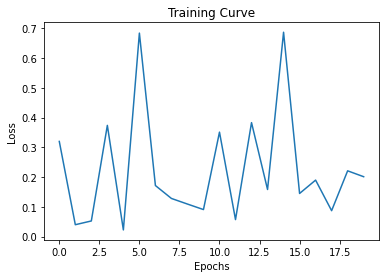

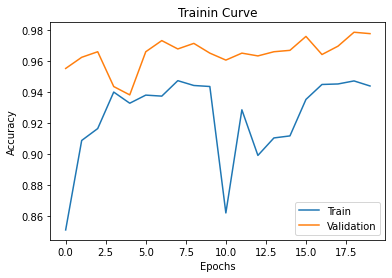

In [ ]:
train_net(model2 , train_iter1, val_iter1 , num_epochs = 20 , learning_rate = 1e-3) 

This model clearly performs poorer than the LTSM model with MaxPooling at the outer layer.

In [ ]:
#Hyperparameter 3: increasing learning rate 

train_iter3 = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)   

val_iter3 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
model3 = LSTM(len(text_field.vocab.stoi),50,2)

Epoch : 1 ; Loss: 0.14189513027668 ; Train_Acc: 0.9588902047030959 ; Val_Acc: 0.9587443946188341 
Epoch : 2 ; Loss: 0.07362302392721176 ; Train_Acc: 0.9835899171037049 ; Val_Acc: 0.9695067264573991 
Epoch : 3 ; Loss: 0.06461400538682938 ; Train_Acc: 0.9934021316190154 ; Val_Acc: 0.979372197309417 
Epoch : 4 ; Loss: 0.02325693890452385 ; Train_Acc: 0.9939096599560142 ; Val_Acc: 0.979372197309417 
Epoch : 5 ; Loss: 0.002581594279035926 ; Train_Acc: 0.9964473016410083 ; Val_Acc: 0.9748878923766816 
Epoch : 6 ; Loss: 0.008887594565749168 ; Train_Acc: 0.9993232955506682 ; Val_Acc: 0.9838565022421525 
Epoch : 7 ; Loss: 0.011543432250618935 ; Train_Acc: 0.9881576721366943 ; Val_Acc: 0.9748878923766816 
Epoch : 8 ; Loss: 0.027976907789707184 ; Train_Acc: 0.9996616477753342 ; Val_Acc: 0.9820627802690582 
Epoch : 9 ; Loss: 0.001873898203484714 ; Train_Acc: 1.0 ; Val_Acc: 0.9820627802690582 
Epoch : 10 ; Loss: 0.0006590744596906006 ; Train_Acc: 1.0 ; Val_Acc: 0.9820627802690582 
Epoch : 11 ; Loss

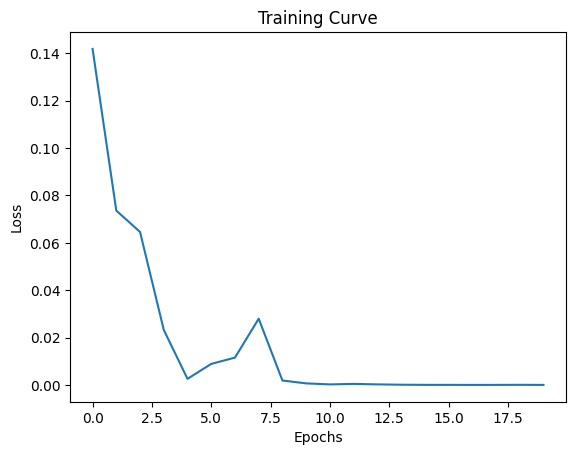

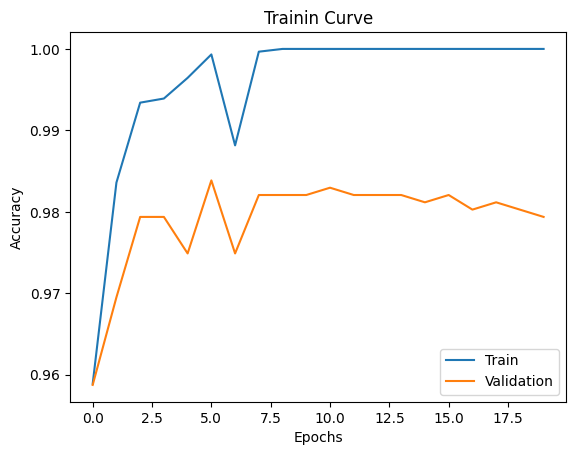

In [ ]:
train_net(model3 , train_iter3, val_iter3 , num_epochs = 20 , learning_rate = 1e-2)

In [ ]:
#Hyperparamter 4: Network Architecture (RNN not LTSM)

class RNN_Network(nn.Module):
  def  __init__(self, input_size, hidden_size, num_class):
    super(RNN_Network, self).__init__()
  
    self.emb = encoding_embedding
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)

  def forward(self , x):
    x = self.emb(x)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, __ = self.rnn(x, h0)
    
    out = self.fc(torch.max(out, dim=1)[0])

    return out


In [ ]:
model4 = RNN_Network(len(text_field.vocab.stoi),50,2)

Epoch : 1 ; Loss: 0.030263634398579597 ; Train_Acc: 0.9676840215439856 ; Val_Acc: 0.968609865470852 
Epoch : 2 ; Loss: 0.03811601549386978 ; Train_Acc: 0.970948261792068 ; Val_Acc: 0.9775784753363229 
Epoch : 3 ; Loss: 0.014181544072926044 ; Train_Acc: 0.9720907458788967 ; Val_Acc: 0.9820627802690582 
Epoch : 4 ; Loss: 0.028280427679419518 ; Train_Acc: 0.9893912191937326 ; Val_Acc: 0.9713004484304932 
Epoch : 5 ; Loss: 0.009872975759208202 ; Train_Acc: 0.9278602905173821 ; Val_Acc: 0.967713004484305 
Epoch : 6 ; Loss: 0.09916245937347412 ; Train_Acc: 0.9487514281051085 ; Val_Acc: 0.9551569506726457 
Epoch : 7 ; Loss: 0.20643843710422516 ; Train_Acc: 0.9355312551003754 ; Val_Acc: 0.9103139013452914 
Epoch : 8 ; Loss: 0.16636158525943756 ; Train_Acc: 0.8780806267341277 ; Val_Acc: 0.7551569506726458 
Epoch : 9 ; Loss: 0.026433158665895462 ; Train_Acc: 0.9585441488493553 ; Val_Acc: 0.9434977578475336 
Epoch : 10 ; Loss: 0.2711670994758606 ; Train_Acc: 0.9440182797453892 ; Val_Acc: 0.943497

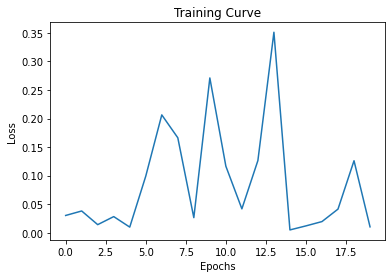

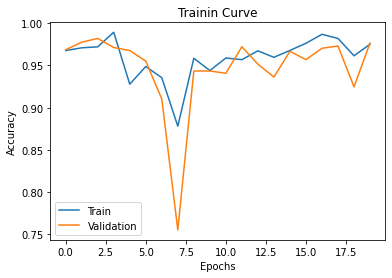

In [ ]:
train_net(model4 , train_iter3, val_iter3 , num_epochs = 20 , learning_rate = 1e-2)

In [ ]:
#Hyperparameter 5: Network Architecture : GRUs

class GRU_Network(nn.Module):
  def  __init__(self, input_size, hidden_size, num_class):
    super(GRU_Network, self).__init__()

    self.emb = encoding_embedding
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)

  def forward(self , x):
    x = self.emb(x)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, __ = self.rnn(x, h0)
    
    out = self.fc(torch.max(out, dim=1)[0])

    return out


In [ ]:
model5 = GRU_Network(len(text_field.vocab.stoi),50,2)

Epoch : 1 ; Loss: 0.24545276165008545 ; Train_Acc: 0.9304716827158479 ; Val_Acc: 0.9766816143497757 
Epoch : 2 ; Loss: 0.1504577100276947 ; Train_Acc: 0.9467928839562592 ; Val_Acc: 0.9713004484304932 
Epoch : 3 ; Loss: 0.020314479246735573 ; Train_Acc: 0.9601762689733965 ; Val_Acc: 0.95695067264574 
Epoch : 4 ; Loss: 0.029984720051288605 ; Train_Acc: 0.9634405092214787 ; Val_Acc: 0.9623318385650225 
Epoch : 5 ; Loss: 0.11110305041074753 ; Train_Acc: 0.9671943855067733 ; Val_Acc: 0.9623318385650225 
Epoch : 6 ; Loss: 0.0535249188542366 ; Train_Acc: 0.9693161416680268 ; Val_Acc: 0.9614349775784753 
Epoch : 7 ; Loss: 0.019490353763103485 ; Train_Acc: 0.9706218377672596 ; Val_Acc: 0.9659192825112107 
Epoch : 8 ; Loss: 0.04401906952261925 ; Train_Acc: 0.971111473804472 ; Val_Acc: 0.95695067264574 
Epoch : 9 ; Loss: 0.11114783585071564 ; Train_Acc: 0.9764974702138077 ; Val_Acc: 0.9730941704035875 
Epoch : 10 ; Loss: 0.051219746470451355 ; Train_Acc: 0.9716011098416844 ; Val_Acc: 0.9488789237

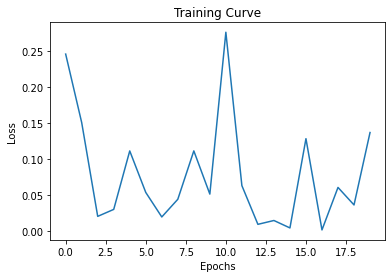

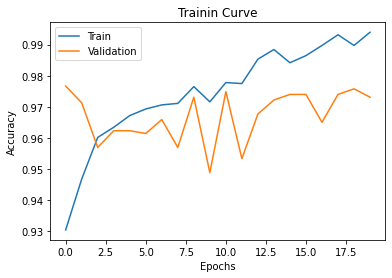

In [ ]:
train_net(model5 , train_iter1 , val_iter1, num_epochs = 20 , learning_rate = 1e-3)

### Part A.3.d - [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset([t for t in valid.examples if t.label==0],
                                             valid.fields)

In [ ]:
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many ep

In [ ]:
# pick the best model and test it for flase positive and false negative outputs. 

In [ ]:
net_acc_pos = get_accuracy(model3 , valid_spam_iter)
print("The rate of false negative is:  " , 1-net_acc_pos)

The rate of false negative is:   0.0888888888888889


In [ ]:
valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

In [ ]:
net_acc_neg = get_accuracy(model3  , valid_nospam_iter)
print("The rate of false positive is:  " , 1-net_acc_neg)

The rate of false positive is:   0.004081632653061273


### Part A.3.e - [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# A false positive can lead the user to miss on some important information that requires his attention, lets say a medical appointment. 
# A false negative on the other hand can lead to severe consequences such as the submission of bank information or some other sort of private data 

## Part A.4. Evaluation - [10 pt]

### Part A.4.a - [1 pt]

Report the final test accuracy of your model.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset([t for t in test.examples if t.label==0],
                                             test.fields)

### Part A.4.b - [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many ep

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

In [ ]:
net_acc_pos = get_accuracy(model3  , test_spam_iter)
print("The rate of false negative is:  " , 1-net_acc_pos)


The rate of false negative is:   0.08783783783783783


In [ ]:
net_acc_neg = get_accuracy(model3  , test_nospam_iter)
print("The rate of false positive is:  " , 1-net_acc_neg)

The rate of false positive is:   0.0041407867494823725


### Part A.4.c - [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
import math
msg = "machine learning is sooo cool!"

In [ ]:
new_msg =[]
for i in enumerate(msg):
  new_msg. append(text_field.vocab.stoi[i[1]])

new_msg = torch.tensor(new_msg).unsqueeze(0)

proba = model3(new_msg)
sigmoid=1/(1+math.exp(-(proba[0][1].item())))

print("The model prediction that the message is a spam is: ", sigmoid)


  


The model prediction that the message is a spam is:  0.013088462721212765


### Part A.4.d - [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam is a difficult task because spams are becoming progrssively harder to differentiate from non-spam messages as spammer or bots sending spam messages are getting better with time. 

As we are facing a binary classification problem one can argue to use linear regression or other machine learning alogirhtms such as SVM. If the problem at hand was a multi-class classification problem, then we can use other approaches such as K-closest neighbours etc... 

SVM has proven to be efficient in classification, therefore I think it would be a simple and cheap machine learning model that could be used as a baseline performance comparison. Steps to build this model are the following:

1 - Data Preparation: Split the data into training, validation and testing with the data being correctly categorized as ham/spam messages.

2 - Encode the data using OneHotEncoding , Word2Vec or CountVectorizer.

3 - Use Sklearn to perform the classification task and find the optimal hyperplane that seperates spam from non spam messages. 





### Part A.4.e - [3 pt]

Try using a learning rate scheduler, such as a step learning rate scheduler or cosine annealing learning rate scheduler. Compare the performance of models with and without learning rate scheduling and discuss any differences observed in terms of accuracy and convergence speed.

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
def step_decay(epoch , initial_lr= 0.1 , drop_rate = 0.5 , epochs_drop = 5 ):
  lr = initial_lr * drop_rate ** (epoch // epochs_drop)
  return lr

In [ ]:
model_lr_scheduling = LSTM(len(text_field.vocab.stoi),50,2)

In [ ]:
# Modified training loop (i.e., addition of step_decay function)

def train_net_lr_sheduling(model,train,valid, num_epochs = 20):
  optimizer = torch.optim.Adam(model.parameters() , lr = 0.1)

  lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)
  criterion = nn.CrossEntropyLoss()
  losses , train_accuracy, valid_accuracy = [],[],[]
  epochs =[]
            

  for epoch in range(num_epochs):
    for batch in train:
      optimizer.zero_grad()
      prediction = model_lr_scheduling(batch.sms[0])
      loss = criterion(prediction, batch.label)
      loss.backward()
      optimizer.step()
    losses.append(float(loss))

    epochs.append(epoch)
    train_accuracy.append(get_accuracy(model , train))
    valid_accuracy.append(get_accuracy(model, valid))
    lr_scheduler.step()

    print("Epoch : {} ; Loss: {} ; Train_Acc: {} ; Val_Acc: {} ".format(epoch+1, loss , 
                                                                        train_accuracy[-1] , valid_accuracy[-1]))

  
  plt.title("Training Curve")
  plt.plot(losses , label = "Train")
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.show()


  plt.title("Trainin Curve")
  plt.plot(epochs , train_accuracy , label = 'Train')
  plt.plot(epochs, valid_accuracy , label = 'Validation')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc = 'best')
  plt.show()

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch : 1 ; Loss: 0.12768349051475525 ; Train_Acc: 0.9687867091793925 ; Val_Acc: 0.9551569506726457 
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch : 2 ; Loss: 0.09691555052995682 ; Train_Acc: 0.9743245510991777 ; Val_Acc: 0.9434977578475336 
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch : 3 ; Loss: 0.05921934172511101 ; Train_Acc: 0.9499916093304246 ; Val_Acc: 0.9013452914798207 
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch : 4 ; Loss: 0.09892686456441879 ; Train_Acc: 0.9872461822453432 ; Val_Acc: 0.9713004484304932 
Adjusting learning rate of group 0 to 5.0000e-02.
Epoch : 5 ; Loss: 0.04308074712753296 ; Train_Acc: 0.9702970297029703 ; Val_Acc: 0.9668161434977578 
Adjusting learning rate of group 0 to 5.0000e-02.
Epoch : 6 ; Loss: 0.0370752327144146 ; Train_Acc: 0.96291324047659 ; Val_Acc: 0.967713004484305 
Adjusting learning rate of group 0 to 5.0000e-02

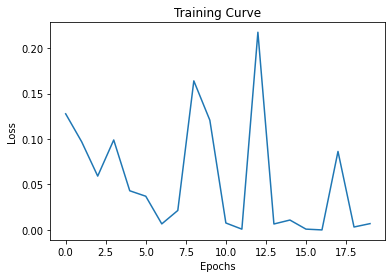

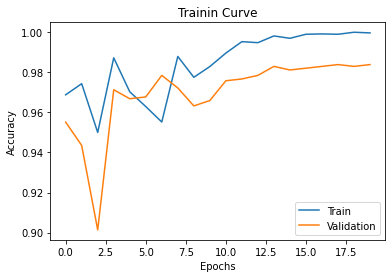

In [ ]:
train_net_lr_sheduling(model_lr_scheduling , train_iter3 , val_iter3,num_epochs = 20)

# PART B - Transfer Learning [24 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 27.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.9.0 requires torch==1.8.0, but you have torch 1.13.1 which is incompatible.


In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2023-03-30 19:08:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z 100%[===================>] 198.65K   294KB/s    in 0.7s    

2023-03-30 19:08:55 (294 KB/s) - ‘smsspamcollection.zip.1’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: readme                  


This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
!pip install fastai==1.0.61
!pip uninstall spacy
!pip install spacy==2.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 KB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 KB 30.7 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19188 sha256=373460ff2243f807984f64dfbb7bfa6b93966c47f20fcd05da86ab277de5d49f
  Stored in directory: /root/.cache/pip/wheels/f6/d8/b0/15cfd7805d39250ac29318105f09b1750683387630d68423e1
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.12
    Uninstalling fastai-2.7.12:
      Successfully uninstalled fastai-2.7.12


Found existing installation: spacy 3.5.1
Uninstalling spacy-3.5.1:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.9/dist-packages/spacy-3.5.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/spacy/*
Proceed (Y/n)? y
  Successfully uninstalled spacy-3.5.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 25.1 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.6
    Uninstalling srsly-2.4.6:
      Successfully uninstalled srsly-2.4.6
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.9/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the ground right is broken or the ground left .
The problem usually starts when the best position off the way means not to show
The problem usually starts when sounds can be released in so - called " hard
The problem usually starts when there is actually something in an apartment a short time
The problem usually starts when the head is on a front - on left attached


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [ ]:
for j in range(5):
  print(lang_mod.predict("The best pizza can be found" , n_words = 10))

The best pizza can be found by selling out a transfer shop in the US
The best pizza can be found between New Scotland and the New
The best pizza can be found in Europe , it was used as the toughest
The best pizza can be found at the New Sport Club in
The best pizza can be found in the UK top brand , called the "


In [ ]:
for j in range(5):
  print(lang_mod.predict("Recurrent Neural Networks are" , n_words = 5))

Recurrent Neural Networks are open to network and network
Recurrent Neural Networks are TV networks in
Recurrent Neural Networks are an all - time network
Recurrent Neural Networks are TV series of
Recurrent Neural Networks are a reference mobile software service


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.563086,4.293756,0.235590,00:04
1,4.839644,3.981250,0.267113,00:02
2,4.387638,3.846433,0.286855,00:02
3,4.074925,3.817465,0.291915,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.600107,3.784945,0.295883,00:02
1,3.550948,3.749168,0.300471,00:02
2,3.497820,3.739521,0.302753,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.405808,3.721832,0.305704,00:03
1,3.381705,3.711379,0.306275,00:03
2,3.367363,3.707099,0.307912,00:03


epoch,train_loss,valid_loss,accuracy,time
0,3.333086,3.693724,0.307887,00:04
1,3.291749,3.669361,0.311458,00:04
2,3.281425,3.660529,0.313343,00:04


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.9/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my thoughts . i would start the day and end it with xxunk should be there every time i xxunk will be then when my every breath has her xxunk life should happen around xxunk life will be named to her .,ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 2.51E-02


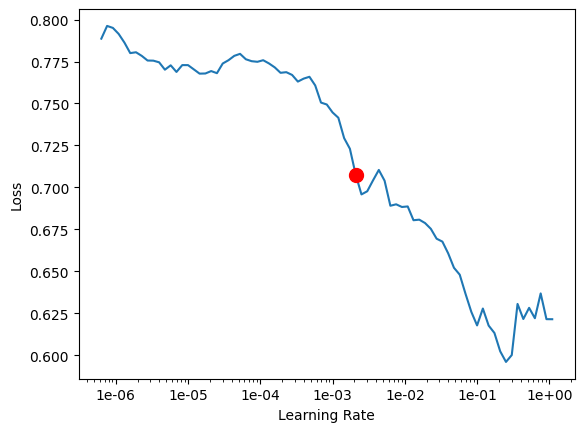

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.404179,0.071193,0.982656,00:03
1,0.192946,0.063962,0.985646,00:04
2,0.140234,0.102538,0.982057,00:04
3,0.108740,0.087609,0.986244,00:03
4,0.091741,0.088445,0.976675,00:04


/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

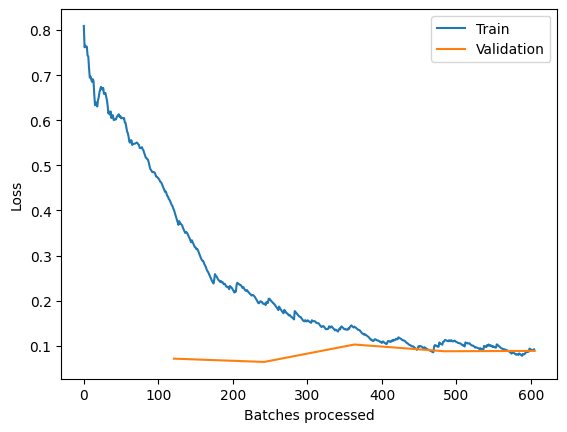

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.9/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-07


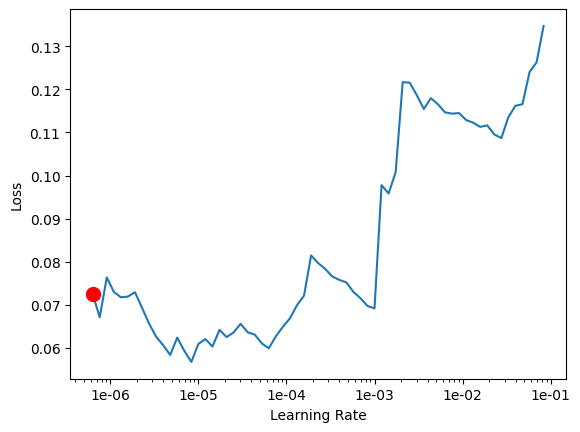

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
prob = learn_classifier.predict('did you buy the groceries for dinner? :)')
print("Probability that the message is NOT spam is" , prob[2][0].item())

Probability that the message is NOT spam is 1.0
tensor(0)


In [ ]:
# predict
prob = learn_classifier.predict('Free entry call back now')
print("Probability that the message is NOT spam is" , prob[2][0].item())

Probability that the message is NOT spam is 0.243739515542984


Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part B.1 Evaluate Performance - [10 pt]

### Part B.1.a - [5 pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

With only 5 epochs of training, the accruacy of the ULMFiT network is 0.98 which is better than the LSTM network architecture provided earlier.
Note that fine truning this network to our data could yield even better results. also note that the training curve trend is much more steady than LSTM. 

In [ ]:
# Feel like this part is still missing some code 

### Part B.1.b - [5 pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [ ]:
from sklearn import metrics
import math

In [ ]:
pred_label = torch.max(valid_preds, 1)[1]
confusion_matrix = metrics.confusion_matrix(list(valid_label), list(pred_label))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

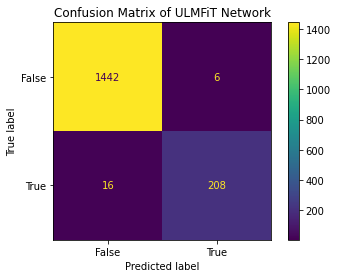

In [ ]:
cm_display.plot()
plt.title("Confusion Matrix of ULMFiT Network")
plt.show()


In [ ]:
# Get validation data labels 

val_iter3 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
k = 0;
for i in val_iter3:
  if k==0:
    val_label = i.label
  else:
    val_label = torch.cat((val_label , i.label ), axis = 0)

  k+=1


In [ ]:
k = 0

for batch in val_iter3:
  y = batch.sms[0]
  y_label = batch.label
  output = model3(y)
  pred = output.max(1 , keepdim = True)[1]

  if k==0:
    val_pred = pred.reshape(1,-1)[0]
  else:
    val_pred = torch.cat((val_pred , pred.reshape(1,-1)[0]) , 0)
  
  k+=1

In [ ]:
val_pred.detach().numpy()

array([0, 0, 0, ..., 0, 0, 0])

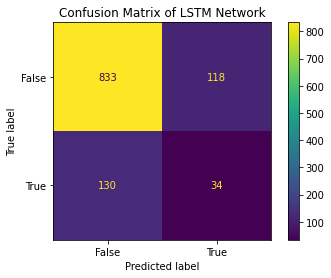

In [ ]:
confusion_matrix = metrics.confusion_matrix(val_label.detach().numpy(), val_pred.detach().numpy())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix of LSTM Network")
plt.show()


## Part B.2 Evaluate on New Data - [14 pt]

### Part B.2.a - [4 pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
msg = "machine learning is sooo cool!"
pred = learn_classifier.predict(msg)
print("The probability that the SMS message is a spam is: " , pred[2][1].item())

The probability that the SMS message is a spam is:  1.635454941503571e-14


### Part B.2.b - [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [ ]:
# Spam Sentences

msg1 = 'Dear valued member, you won a free trip to Maldives!'
msg2 = 'URGENT, PLEASE HELP! I am stranded on a desert island, send 100000$'
msg3 = 'BRAND NEW APP ON THIS LINK, only pay 3$!'
msg4 = 'ITS YOUR CHANCE to win 100$ in bitcoin'
msg5 = 'LIMITED TIME OFFER call to be the first to get this new ringtone!!'
msgs = [msg1 , msg2 , msg3 , msg4, msg5]

In [ ]:
# Testing on ULMFiT model
spam_num = 0
for msg in msgs:
  pred = learn_classifier.predict(msg)
  print(pred[1])

  if pred[1]==1:
    spam_num+=1
    
spam_acc = spam_num/5
print("The accuracy of predicting spam is:",spam_acc)





tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
The accuracy of predicting spam is: 1.0


In [ ]:
print("LSTM Network Prediction")

spam_num=0

for msg in msgs:
  spam_msg = []
  for i in enumerate(msg):
    spam_msg.append(text_field.vocab.stoi[i[1]])

  spam_msg=torch.tensor(spam_msg).unsqueeze(0)
  proba=model3(spam_msg)
  sigmoid=1/(1+math.exp(-(proba[0][1].item())))
  print("The probability that the SMS message is a spam is: " , sigmoid)

  pred=proba.max(1,keepdim=True)[1]
  if pred.item()==1:
    spam_num+=1

spam_num=spam_num/len(msgs)
print("The accuracy of detecting spam emails is:", spam_num)


LSTM Network Prediction
The probability that the SMS message is a spam is:  0.010459393633985513
The probability that the SMS message is a spam is:  0.9971003709183759
The probability that the SMS message is a spam is:  0.039966586497387
The probability that the SMS message is a spam is:  0.028654494154035714
The probability that the SMS message is a spam is:  0.012726494104469263
The accuracy of detecting spam emails is: 0.2


### Part B.2.c - [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [ ]:
msg1 = "You're signed up to receive a weekly report of some notifications from your Canvas account."
msg2 = "Midterm marks and solutions are now posted, and you can pick up the midterms in class."
msg3 = "It’s March. Exams are coming up and final papers are due soon. And when you’re busy or stressed, we know it can be hard to keep up healthy eating habits."
msg4 = "Now is your opportunity to evaluate your courses and instructors. We appreciate you taking the time to provide comments to your instructor, as they can use this feedback to reflect upon their own work in these challenging times."
msg5 = "Exams are on the horizon and we've got the goods to help you feel prepared and supported this season"

msgs2 = [msg1 , msg2, msg3, msg4 , msg5]

In [ ]:
non_spam = 0
for msg in msgs2:
  pred = learn_classifier.predict(msg)
  print("The probability that the SMS message is a spam is: " , pred[2][1].item())

  if pred[1]==0:
    non_spam +=1

non_spam_acc = non_spam / len(msgs2)

print("The accuracy of ULMFiT model to detect non-spam messages is:", non_spam_acc)


The probability that the SMS message is a spam is:  0.3782453238964081
The probability that the SMS message is a spam is:  0.03203311190009117
The probability that the SMS message is a spam is:  0.004212330561131239
The probability that the SMS message is a spam is:  0.001407245988957584
The probability that the SMS message is a spam is:  1.5675824442951125e-06
The accuracy of ULMFiT model to detect non-spam messages is: 1.0


In [ ]:
print("LSTM Network Prediction")

spam_num=0

for msg in msgs:
  spam_msg = []
  for i in enumerate(msg):
    spam_msg.append(text_field.vocab.stoi[i[1]])

  spam_msg=torch.tensor(spam_msg).unsqueeze(0)
  proba=model3(spam_msg)
  sigmoid=1/(1+math.exp(-(proba[0][1].item())))
  print("The probability that the SMS message is a spam is: " , sigmoid)

  pred=proba.max(1,keepdim=True)[1]
  if pred.item()==1:
    spam_num+=1
    
spam_num=spam_num/len(msgs)
print("The accuracy of detecting non-spam emails is:", 1-spam_num)

LSTM Network Prediction
The probability that the SMS message is a spam is:  0.010459393633985513
The probability that the SMS message is a spam is:  0.9971003709183759
The probability that the SMS message is a spam is:  0.039966586497387
The probability that the SMS message is a spam is:  0.028654494154035714
The probability that the SMS message is a spam is:  0.012726494104469263
The accuracy of detecting non-spam emails is: 0.8


### Part B.2.d - [4pt]
Experiment with different architectures for the classifier, such as using a bidirectional LSTM or a GRU. Compare the performance of models with different architectures and discuss any differences observed.

In [ ]:
class LSTM_bi(nn.Module):
  def  __init__(self, input_size, hidden_size,num_layers, num_class):
    super(LSTM_bi, self).__init__()
  
    self.emb = encoding_embedding
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True ,bidirectional=True)
    self.fc = nn.Linear(hidden_size*2, num_class)

  def forward(self , x):
    x = self.emb(x)

    h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)

val_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
model = LSTM_bi(len(text_field.vocab.stoi),50,1,2)

Epoch : 1 ; Loss: 0.09966495633125305 ; Train_Acc: 0.910530749789385 ; Val_Acc: 0.9605381165919282 
Epoch : 2 ; Loss: 0.17545181512832642 ; Train_Acc: 0.9393428812131424 ; Val_Acc: 0.9757847533632287 
Epoch : 3 ; Loss: 0.21470409631729126 ; Train_Acc: 0.9406908171861836 ; Val_Acc: 0.9766816143497757 
Epoch : 4 ; Loss: 0.030034448951482773 ; Train_Acc: 0.9425442291491154 ; Val_Acc: 0.9766816143497757 
Epoch : 5 ; Loss: 0.32629790902137756 ; Train_Acc: 0.9076663858466723 ; Val_Acc: 0.9695067264573991 
Epoch : 6 ; Loss: 0.4326644539833069 ; Train_Acc: 0.9464195450716091 ; Val_Acc: 0.9766816143497757 
Epoch : 7 ; Loss: 0.13723991811275482 ; Train_Acc: 0.9383319292333614 ; Val_Acc: 0.9802690582959641 
Epoch : 8 ; Loss: 0.314397931098938 ; Train_Acc: 0.93681550126369 ; Val_Acc: 0.9775784753363229 
Epoch : 9 ; Loss: 0.07763948291540146 ; Train_Acc: 0.9385004212299916 ; Val_Acc: 0.979372197309417 
Epoch : 10 ; Loss: 0.0793309360742569 ; Train_Acc: 0.9423757371524852 ; Val_Acc: 0.97937219730941

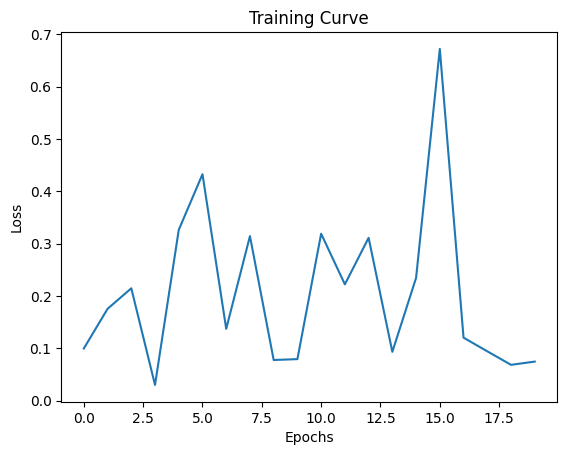

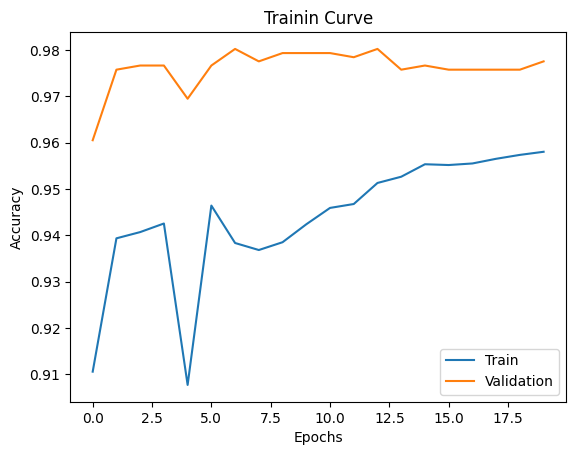

In [ ]:
train_net(model , train_iter, val_iter , num_epochs = 20 , learning_rate = 1e-3)

In [ ]:
import math

In [ ]:
# testing on Spam messages loaded previously

print("Bidirectional LSTM Network Prediction")

spam_num=0

for msg in msgs:
  spam_msg = []
  for i in enumerate(msg):
    spam_msg.append(text_field.vocab.stoi[i[1]])

  spam_msg=torch.tensor(spam_msg).unsqueeze(0)
  proba=model(spam_msg)
  sigmoid=1/(1+math.exp(-(proba[0][1].item())))
  print("The probability that the SMS message is a spam is: " , sigmoid)

  pred=proba.max(1,keepdim=True)[1]
  if pred.item()==1:
    spam_num+=1

spam_num=spam_num/len(msgs)
print("The accuracy of detecting spam emails is:", spam_num)

# The model yield a better result by predicting one additional message to be a spam message compared 
# to the regular LSTM network architecture even though the loss curve can be improved to reduce 
# its inconsistency acros different epochs. 

Bidirectional LSTM Network Prediction
The probability that the SMS message is a spam is:  0.37040290685656974
The probability that the SMS message is a spam is:  0.8944458070631477
The probability that the SMS message is a spam is:  0.44209220828780554
The probability that the SMS message is a spam is:  0.9031574969233525
The probability that the SMS message is a spam is:  0.45622993932632255
The accuracy of detecting spam emails is: 0.4


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data.ipynb to html
/usr/local/lib/python3.9/dist-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 1472842 bytes to LAB_4_Sequential_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus